# Systems of more than one variable

Almost all the problems that we will want to solve are systems of more than one variable.  For example, the Navier-Stokes equation for fluid flow, $C^0$-conforming discretisations of the Cahn-Hilliard equation for phase separation, or systems that couple different physical processes.

Firedrake supports specifying and solving such systems in *mixed* function spaces.  Here we will use a dual formulation of the Poisson equation as a simple introductory example.

These systems of equations have a block algebraic form, and we will also look at some of the support for efficient preconditioning strategies that Firedrake offers.

## Problem setup
Recall the primal form of the Poisson equation.  Find $u$ satisfying

$$
\begin{align}
\nabla^2 u &= -f \quad\text{in $\Omega$}, \\
   u &= u_0 \quad\text{on $\Gamma_D$},\\
   \nabla u \cdot n &= g \quad\text{on $\Gamma_N$.}
   \end{align}$$
   
We obtain the dual form by introducing a vector-valued flux $\sigma = \nabla u$.  Substituting, the problem becomes.  Find $(\sigma, u)$ satisfying

$$
\begin{align}
\sigma - \nabla u &= 0 \quad \text{in $\Omega$}, \\
\nabla \cdot \sigma &= -f \quad \text{in $\Omega$}, \\
u &= u_0 \quad \text{on $\Gamma_D$},\\
\sigma \cdot n &= g \quad\text{on $\Gamma \setminus \Gamma_D =: \Gamma_N$.}
\end{align}
  $$
  
For the variational formulation, we introduce a pair of function spaces, $\Sigma$ and $V$, and seek $(\sigma, u) \in \Sigma \times V$ such that:

$$
\begin{align}
\int_\Omega (\sigma \cdot \tau + \nabla \cdot \tau u)\,\text{d} x &= 
  \int_\Gamma \tau \cdot n u\,\text{d}s \quad \forall \tau \in \Sigma,\\ 
\int_\Omega (\nabla\cdot\sigma)v\,\text{d} x &= - \int_\Omega f v\,\text{d}x 
\quad \forall v \in V.
\end{align}
$$

Notice how the weak condition in the primal form turns into a strong condition on the auxiliary variable $\sigma$ and the strong condition on $u$ in the primal form appears as a weak condition on $\sigma$.

For this problem we will solve with homogeneous Dirichlet (strong) conditions $u_0 = 0$ on the boundary of a square domain $\Omega = [0, 1]^2$, and will choose $f = 10\exp(-100((x-0.5)^2 + (y-0.5)^2))$.

As should be familiar by now, we start by importing the Firedrake package and setting up the discrete problem domain.

In [1]:
# This magic makes plots appear in the browser
%matplotlib notebook
import matplotlib.pyplot as plt

# Load Firedrake on Colab
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

from firedrake import *

--2022-06-08 13:34:19--  https://fem-on-colab.github.io/releases/firedrake-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3255 (3.2K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   3.18K  --.-KB/s    in 0s      

2022-06-08 13:34:19 (37.0 MB/s) - ‘/tmp/firedrake-install.sh’ saved [3255/3255]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/dbefa73/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/dbefa73/releases/pybind11-install.sh 

In [2]:
from time import time

N = 20

mesh = UnitSquareMesh(N, N)

We need to choose an LBB-stable finite element pair for $W = V\times\Sigma$, one choice is the Raviart-Thomas space of degree $k$ for $\Sigma$ and discontinuous polynomials of degree $k$ for $V$, here we choose $k = 1$.

In [3]:
rt = FiniteElement("Raviart-Thomas", triangle, 2, variant="integral")
Sigma = FunctionSpace(mesh, rt)
V = FunctionSpace(mesh, "DG", 1)

Note that Firedrake inherits the convention from FEniCS that the specified element degree is the degree of the smallest polynomial space that spans the space of the element.  The lowest order Raviart-Thomas element contains all the constants and some linear functions, hence we specify degree 1.

Now we build the mixed finite element space $W$, and create test and trial functions.

In [4]:
W = Sigma * V

sigma, u = TrialFunctions(W)
tau, v = TestFunctions(W)

The forcing function $f$ is created as an expression, and we're ready to set up the variational problem.

In [5]:
x, y = SpatialCoordinate(mesh)
f = 10*exp(-100*((x - 0.5)**2 + (y - 0.5)**2))

a = dot(sigma, tau)*dx + div(tau)*u*dx + div(sigma)*v*dx
L = -f*v*dx

We need a solution variable, and then we can solve the problem. The problem is symmetric, but indefinite, so we can use the MINRES Krylov method.

In [6]:
wh = Function(W)
solve(a == L, wh, solver_parameters={"ksp_type": "minres", "pc_type": "none"})

Let's have a look at the solution.
Here we're using the matplotlib [subplots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html) function to create a single figure with two subplots oriented in two columns, both of which share the same $x$- and $y$-axes.
For each subplot, we're making the aspect ratio of each axis the same, and we're adding a title.
Matplotlib can render titles and other labels using [TeX](https://matplotlib.org/tutorials/text/mathtext.html), which we're using to make the $\sigma$ symbol display nicely in the first title.

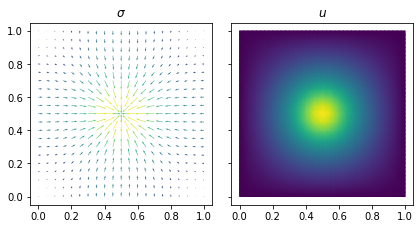

In [7]:
# NBVAL_IGNORE_OUTPUT
sigmah, uh = wh.split()
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)

quiver(sigmah, axes=axes[0])
axes[0].set_aspect("equal")
axes[0].set_title("$\sigma$")

tripcolor(uh, axes=axes[1])
axes[1].set_aspect("equal")
axes[1].set_title("$u$")

plt.tight_layout()

## Improving the solver performance

Most problems you'll encounter will require effective *preconditioning* to achieve mesh and parameter *independent* convergence.  By this we mean that the number of iterations to obtain the solution is independent of both the mesh refinement, and hopefully also, any coefficient variability.  Here, we have a constant-coefficient problem, so we only need to worry about mesh refinement.

If we had a primal Poisson problem, we could treat the issue quite easily using an algebraic multigrid preconditioner such as hypre.  However, for this dual formulation it is slightly more complicated.

First, we'll illustrate the issue, then look at some possible solutions.

We're going to be running the same problem over and over again at a range of mesh resolutions, so to avoid writing the code again and again we'll wrap the problem up in a function.

In [8]:
def create_solver(N, solver_parameters, aP=None):
    mesh = UnitSquareMesh(N, N)
    Sigma = FunctionSpace(mesh, rt)
    V = FunctionSpace(mesh, "DG", 1)
    W = Sigma * V

    sigma, u = TrialFunctions(W)
    tau, v = TestFunctions(W)
    x, y = SpatialCoordinate(mesh)
    f = 10*exp(-100*((x - 0.5)**2 + (y - 0.5)**2))

    a = dot(sigma, tau)*dx + div(tau)*u*dx + div(sigma)*v*dx
    L = -f*v*dx
    
    wh = Function(W)
    if aP is not None:
        aP = aP(W)
    problem = LinearVariationalProblem(a, L, wh, aP=aP)
    solver = LinearVariationalSolver(problem, solver_parameters=solver_parameters)
    return solver

Let's try solving the problem using MINRES with incomplete Cholesky as a preconditioner.

In [9]:
# NBVAL_SKIP
parameters = {"ksp_type": "minres", "mat_type": "aij", "pc_type": "icc"}
from firedrake.solving_utils import KSPReasons
for N in [5, 10, 25, 50]:
    solver = create_solver(N, parameters)
    cpu_timestamp = time()
    solver.solve()
    cpu_time = time() - cpu_timestamp
    print("N = {:3d}, iterations = {:3d}, converged reason = {:s}, time = {:.3f}s".format(
        N, solver.snes.ksp.getIterationNumber(), 
        KSPReasons[solver.snes.ksp.getConvergedReason()],
        cpu_time))

N =   5, iterations = 133, converged reason = CONVERGED_RTOL, time = 0.025s
N =  10, iterations = 213, converged reason = CONVERGED_RTOL, time = 0.039s
N =  25, iterations = 451, converged reason = CONVERGED_RTOL, time = 0.306s
N =  50, iterations = 827, converged reason = CONVERGED_RTOL, time = 2.318s


### Schur complement approaches

Many state of the art solution methods for systems of equations rely on block factorisation and block inverses to construct good preconditioners.  Firedrake supports these through PETSc's `fieldsplit` preconditioning type. The mixed Poisson problem

$$
\begin{align}
\int_\Omega (\color{#800020}{\sigma \cdot \tau} + \color{#2A52BE}{\nabla \cdot \tau u})\,\text{d} x &= 
  \int_\Gamma \color{#2A52BE}{\tau \cdot n u}\,\text{d}s \quad \forall \tau \in \Sigma,\\ 
\int_\Omega \color{#BE962A}{(\nabla\cdot\sigma)v}\,\text{d} x &= - \int_\Omega f v\,\text{d}x 
\quad \forall v \in V.
\end{align}
$$

is a block system with matrix

$$
\mathcal{A} = \begin{split}\left(\begin{matrix} \color{#800020}A & \color{#2A52BE}B \\
\color{#BE962A}C & 0 \end{matrix}\right),\end{split}
$$

admitting a factorisation

$$
\begin{split}\left(\begin{matrix} I & 0 \\ \color{#BE962A}C \color{#800020}{A^{-1}} & I\end{matrix}\right)
\left(\begin{matrix}\color{#800020}A & 0 \\ 0 & S\end{matrix}\right)
\left(\begin{matrix} I & \color{#800020}{A^{-1}} \color{#2A52BE}B \\ 0 & I\end{matrix}\right),\end{split}
$$

with $S = -\color{#BE962A}C \color{#800020}{A^{-1}} \color{#2A52BE}B$ the *Schur complement*.  This has an inverse:

$$
\begin{split}\left(\begin{matrix} I & -\color{#800020}{A^{-1}}\color{#2A52BE}B \\ 0 & I \end{matrix}\right)
\left(\begin{matrix} \color{#800020}{A^{-1}} & 0 \\ 0 & S^{-1}\end{matrix}\right)
\left(\begin{matrix} I & 0 \\ -\color{#BE962A}C\color{#800020}{A^{-1}} & I\end{matrix}\right).\end{split}
$$

In particular, note that if we drop some of the terms in the factorisation and write

$$ 
\mathcal{P} = \begin{split}\left(\begin{matrix} \color{#800020}A & 0 \\ 0 & -\color{#BE962A}C \color{#800020}{A^{-1}} \color{#2A52BE}B\end{matrix}\right)\end{split},
$$

then the system $\mathcal{P}^{-1}\mathcal{A}$ has at most four distinct eigenvalues, and so a Krylov method applied to this preconditioned system will converge quickly [Murphy, Golub, and Wathen (2000)](https://doi.org/10.1137/S1064827599355153).

This approach therefore reduces the problem of finding an inverse of $\mathcal{A}$ into the (hopefully simpler) problem of finding good inverses for blocks thereof.

Let's try this out on our problem:

In [19]:
# NBVAL_SKIP
parameters = {"ksp_type": "minres", 
              "mat_type": "aij", 
              "pc_type": "fieldsplit",
              "pc_fieldsplit_type": "schur",
              "pc_fieldsplit_schur_fact_type": "diag",
              "fieldsplit_0_ksp_type": "cg",
              "fieldsplit_0_pc_type": "icc",
              "fieldsplit_0_ksp_rtol": 1e-12,
              "fieldsplit_1_ksp_type": "cg",
              "fieldsplit_1_pc_type": "none",
              "fieldsplit_1_ksp_rtol": 1e-12}
from firedrake.solving_utils import KSPReasons
for N in [5, 10, 25, 50]:
    solver = create_solver(N, parameters)
    cpu_timestamp = time()
    solver.solve()
    cpu_time = time() - cpu_timestamp
    print("N = {:3d}, iterations = {:1d}, converged reason = {:s}, time = {:.3f}s".format(
        N, solver.snes.ksp.getIterationNumber(), 
        KSPReasons[solver.snes.ksp.getConvergedReason()],
        cpu_time))
    # question
    print("iterations to invert S:", solver.snes.ksp.pc.getFieldSplitSubKSP()[1].getIterationNumber())

N =   5, iterations = 2, converged reason = CONVERGED_RTOL, time = 0.059s
iterations to invert S: 41
N =  10, iterations = 2, converged reason = CONVERGED_RTOL, time = 0.113s
iterations to invert S: 85
N =  25, iterations = 2, converged reason = CONVERGED_RTOL, time = 1.017s
iterations to invert S: 175
N =  50, iterations = 2, converged reason = CONVERGED_RTOL, time = 9.354s
iterations to invert S: 323


Great, we got good algorithmic convergence.  Unfortunately, this is still very slow.  This is because the Schur complement operator $S$ is effectively an elliptic operator and we're inverting it with an unpreconditioned Krylov method.

## PETSc options, an aside

Above we saw a larger set of PETSc options than previously.  This warrants a more in depth explanation.  PETSc objects are configurable at *runtime*, and the primary mechanism for controlling their behaviour is the PETSc *options database*.  The "programming language" of these options consists of two operations:

- Value assignment
- string concatenation

Each object has an options *prefix* that can be used to distinguish it from other objects (of the same, or different, type).  For example, the linear solve object in PETSc is a `KSP`, and its prefix is `"ksp_"`.  Hence, `"ksp_type": "minres"` says "Set the type of the KSP object in this solve to minres".

Similarly, the preconditioner is wrapped up in a `PC` object, with prefix `"pc_"`.  Here, we say `"pc_type": "fieldsplit"` which sets the preconditioner type to be `"fieldsplit"`.

The type of the fieldsplit `PC` is controlled with `"pc_fieldsplit_type": "schur"`.  This kind of block preconditioner needs inverses for the blocks.  These are provided by KSP objects.  So that we can configure them separately from the main "outer" KSP, they have separate prefixes: `"fieldsplit_0_"` and `"fieldsplit_1_"`.  The former controls the behaviour for $A^{-1}$, the latter for $S^{-1}$.

Although this system takes some getting used to, and looks somewhat verbose, it provides a lot of flexibility.  We do not need to modify the code itself, only the options used, to change configuration of the solver.

## Exercise

Determine how the iterations required to invert the $S$ change when the mesh size is increased.

- Hint: The KSPs for the fieldsplit solves are available as `solver.snes.ksp.pc.getFieldSplitSubKSP()` 


In [ ]:
#See cell above add: 
#solver.snes.ksp.pc.getFieldSplitSubKSP()[1].getIterationNumber()
# the iterations grow as the matrix gets bigger - not mesh independent!

## Providing an approximation to $S$

Our problem is that we haven't provided a preconditioning matrix to invert $S$.  If $A$ is such that $\text{diag}(A)^{-1}$ is a good approximation to $A^{-1}$, then a sparse approximation $\tilde{S} = -C \text{diag}(A)^{-1} B$ is a good approximation to $S$.  PETSc allows us to create this purely using options:

In [ ]:
# NBVAL_SKIP
parameters = {"ksp_type": "minres", 
              "mat_type": "aij", 
              "pc_type": "fieldsplit",
              "pc_fieldsplit_type": "schur",
              "pc_fieldsplit_schur_fact_type": "diag",
              # Construct \tilde{S} using C diag(A)^{-1} B
              "pc_fieldsplit_schur_precondition": "selfp",
              "fieldsplit_0_ksp_type": "cg",
              "fieldsplit_0_pc_type": "icc",
              "fieldsplit_0_ksp_rtol": 1e-12,
              "fieldsplit_1_ksp_type": "cg",
              "fieldsplit_1_ksp_converged_reason": None,
              # Use algebraic multigrid on \tilde{S}
              "fieldsplit_1_pc_type": "hypre",
              "fieldsplit_1_ksp_rtol": 1e-12}
from firedrake.solving_utils import KSPReasons
for N in [5, 10, 25, 50, 100]:
    solver = create_solver(N, parameters)
    cpu_timestamp = time()
    solver.solve()
    cpu_time = time() - cpu_timestamp
    print("N = {:3d}, iterations = {:1d}, converged reason = {:s}, time = {:.3f}s\n".format(
        N, solver.snes.ksp.getIterationNumber(), 
        KSPReasons[solver.snes.ksp.getConvergedReason()],
        cpu_time))

We could now think about reducing the tolerance on the inner solves, reducing the accuracy of the approximation inverses.  For example, approximating $A^{-1}$ and $S^{-1}$ purely by the application of the preconditioner.

In [ ]:
# NBVAL_SKIP
parameters = {"ksp_type": "minres", 
              "mat_type": "aij", 
              "pc_type": "fieldsplit",
              "pc_fieldsplit_type": "schur",
              "pc_fieldsplit_schur_fact_type": "diag",
              # Construct \tilde{S} using C diag(A)^{-1} B
              "pc_fieldsplit_schur_precondition": "selfp",
              "fieldsplit_0_ksp_type": "preonly",
              "fieldsplit_0_pc_type": "icc",
              "fieldsplit_1_ksp_type": "preonly",
              # Use algebraic multigrid on \tilde{S}
              "fieldsplit_1_pc_type": "hypre"}
from firedrake.solving_utils import KSPReasons
for N in [5, 10, 25, 50, 100]:
    solver = create_solver(N, parameters)
    cpu_timestamp = time()
    solver.solve()
    cpu_time = time() - cpu_timestamp
    print("N = {:3d}, iterations = {:2d}, converged reason = {:s}, time = {:.3f}s".format(
        N, solver.snes.ksp.getIterationNumber(), 
        KSPReasons[solver.snes.ksp.getConvergedReason()],
        cpu_time))

Developing efficient solvers for block systems using this approach is quite an experimental science.  The best approach will vary depending on how good the preconditioners you have available for the individual blocks are, how many degrees of freedom the system has, any coefficient variations, the tolerance to which you wish to solve the problem, and probably many more.

The strength of Firedrake and PETSc in this set up is the ease with which we can experiment, without needing to recompile code.  For a few more details, and further pointers, you can look at the [extended Firedrake demo on this topic](http://firedrakeproject.org/demos/saddle_point_systems.py.html).